In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anambra-with-geo/anambra_with_geo.csv


In [3]:
!pip install pandas geopandas shapely geopy scipy

In [4]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
from geopy.distance import geodesic
import geopandas as gpd
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load your data
file_path = '/kaggle/input/anambra-with-geo/anambra_with_geo.csv'
data = pd.read_csv(file_path)

In [7]:
# Ensure Latitude and Longitude columns are numeric
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')

# Drop rows with missing coordinates
data = data.dropna(subset=['Latitude', 'Longitude'])

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))

# Convert latitude and longitude to radians
gdf['Latitude_rad'] = np.radians(gdf['Latitude'])
gdf['Longitude_rad'] = np.radians(gdf['Longitude'])

# Create KDTree for fast spatial indexing
tree = KDTree(gdf[['Latitude_rad', 'Longitude_rad']].values)

# Function to find neighbors within a radius
def find_neighbors_within_radius(tree, gdf, radius_km):
    neighbors_dict = {}
    radius_rad = radius_km / 6371.0  # Convert radius to radians
    for idx, row in gdf.iterrows():
        center_point = np.array([row['Latitude_rad'], row['Longitude_rad']])
        indices = tree.query_ball_point(center_point, radius_rad)
        neighbors = gdf.iloc[indices]['PU-Name'].tolist()
        neighbors.remove(row['PU-Name'])  # Remove self from neighbors
        neighbors_dict[row['PU-Name']] = neighbors
    return neighbors_dict

# Find neighbors within 1km radius
neighbors_within_1km = find_neighbors_within_radius(tree, gdf, 1)

# Inspect the dictionary to understand its structure
print(f"Sample neighbors_within_1km: {list(neighbors_within_1km.items())[:5]}")

# Convert neighbors dictionary to DataFrame
neighbors_df = pd.DataFrame(list(neighbors_within_1km.items()), columns=['PU-Name', 'Neighbors'])

# Merge neighbors with original DataFrame
data_with_neighbors = pd.merge(data, neighbors_df, on='PU-Name', how='left')

Sample neighbors_within_1km: [("ST. CHARLE'S SCHOOL", ['COMMUNITY PRY. SCHOOL III', 'COMMUNITY PRIMARY SCHOOL   BLOCK B', 'COMMUNITY PRY. SCHOOL IV', 'COMMUNITY PRY. SCHOOL IV', 'COMMUNITY PRY. SCHOOL I', 'COMMUNITY PRY. SCHOOL II', 'COMMUNITY PRY. SCHOOL III', 'COMMUNITY SECONDARY SCHOOL OZALLA', 'COMMUNITY SEC. SCHOOL  I', 'COMMUNITY SEC. SCHOOL II', 'OZALLA/AKUKWA P.O.', 'LONDON SCIENCE I', 'LONDON SCIENCE III', 'LONDON SCIENCE III', 'CENTRAL SCHOOL IV', 'CENTRAL SCHOOL IV', 'UMUEZE VILLAGE SQUARE', 'CENTRAL SCHOOL III', 'EGBUIKE PRY. SCHOOL', 'AGBAELU VILLAGE HALL II', 'UHUALA HALL II', 'CENTRAL SCHOOL II', 'EZIAGULU VILLAGE HALL II', 'OTIOGBATA HALL   III', 'OTIOGBATA HALL  II', 'OTIOGBATA HALL  I', 'OKWU HALL  II', 'EZINKWO PRY SCHOOL  II', 'EZINKWO PRY SCHOOL  I', 'AMAUDO SQUARE II', 'EZEKANNAGHA  SQUARE I', 'EZEKANNAGHA SQUARE II', 'EZIAGULU PRY. SCHOOL', 'NWANEBO PRY. SCHOOL I', 'NWANEBO PRY. SCHOOL II', 'NWANEBO PRY. SCHOOL II', 'OLD AKPUNOJI I', 'AKPUNOJI COMMUNITY SCHOOL II

In [8]:
# Function to find outliers and calculate outlier scores
def calculate_outlier_scores(row, data, columns, threshold=2):
    if row['Neighbors']:
        neighbors = data[data['PU-Name'].isin(row['Neighbors'])]
        scores = {}
        for col in columns:
            mean = neighbors[col].mean()
            std = neighbors[col].std()
            if std > 0:
                score = abs(row[col] - mean) / std
                if score > threshold:
                    scores[col] = round(score, 2)  # Round to 2 significant figures
        return scores
    return None

# Apply the function to calculate outlier scores in voting numbers
voting_columns = ['APC', 'LP', 'PDP', 'NNPP']
data_with_neighbors['Outlier_Scores'] = data_with_neighbors.apply(
    lambda row: calculate_outlier_scores(row, data_with_neighbors, voting_columns), axis=1)

# Filter rows with outlier scores that are dictionaries
outliers_df = data_with_neighbors[data_with_neighbors['Outlier_Scores'].apply(lambda x: isinstance(x, dict))]

# Explode the outlier scores dictionary into separate rows
outliers_exploded = outliers_df.explode('Outlier_Scores')

# Create a DataFrame from the exploded outlier scores
outlier_details = pd.DataFrame([
    (pu_name, col, score, neighbors)
    for pu_name, scores, neighbors in zip(outliers_exploded['PU-Name'], outliers_exploded['Outlier_Scores'], outliers_exploded['Neighbors'])
    for col, score in (scores.items() if isinstance(scores, dict) else [])
], columns=['PU-Name', 'Voting_Column', 'Outlier_Score', 'Neighbors'])

# Sort the outlier details by Outlier_Score in descending order
sorted_outliers = outlier_details.sort_values(by='Outlier_Score', ascending=False)

# Merge the outlier scores back into the original DataFrame
data_with_outliers = pd.merge(data_with_neighbors, sorted_outliers, on='PU-Name', how='left')

In [9]:
# Save the updated DataFrame to a new CSV file
updated_file_path = '/kaggle/working/anambra_with_outliers.csv'
data_with_outliers.to_csv(updated_file_path, index=False)

# Print the updated DataFrame with outlier scores
print(data_with_outliers.head())

     State     LGA        Ward       PU-Code              PU-Name  Latitude  \
0  ANAMBRA  AGUATA  ACHINA   I  04-01-01-001  ST. CHARLE'S SCHOOL  6.008584   
1  ANAMBRA  AGUATA  ACHINA   I  04-01-01-005       AMANKWU SQUARE  6.008584   
2  ANAMBRA  AGUATA  ACHINA   I  04-01-01-006     COOPERATIVE HALL  6.008584   
3  ANAMBRA  AGUATA  ACHINA   I  04-01-01-008      OCHIEOBU SQUARE  6.008584   
4  ANAMBRA  AGUATA  ACHINA   I  04-01-01-010   OYE MOTOR PARK  II  5.965620   

   Longitude  Accredited_Voters  Registered_Voters  Results_Found  ...  APC  \
0   7.100949                171                630           True  ...    0   
1   7.100949                153                500           True  ...    3   
2   7.100949                121                386           True  ...    0   
3   7.100949                134                426           True  ...    0   
4   7.119106                 63                166           True  ...    4   

    LP  PDP  NNPP                                 

In [17]:
# Create a map centered around Anambra, Nigeria
anambra_map = folium.Map(location=[6.22089970, 6.93695590], zoom_start=8)

# Add points to the map
for index, row in data_with_outliers.iterrows():
    if not pd.isna(row['Outlier_Score']):
        color = 'red'  # Highlight outliers in red
        popup_info = f"PU-Name: {row['PU-Name']}<br>Outliers: {row['Outlier_Score']}"
    else:
        color = 'blue'
        popup_info = f"PU-Name: {row['PU-Name']}<br>Votes: {row['APC']} (APC), {row['LP']} (LP), {row['PDP']} (PDP), {row['NNPP']} (NNPP)"
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_info, max_width=300)
    ).add_to(anambra_map)

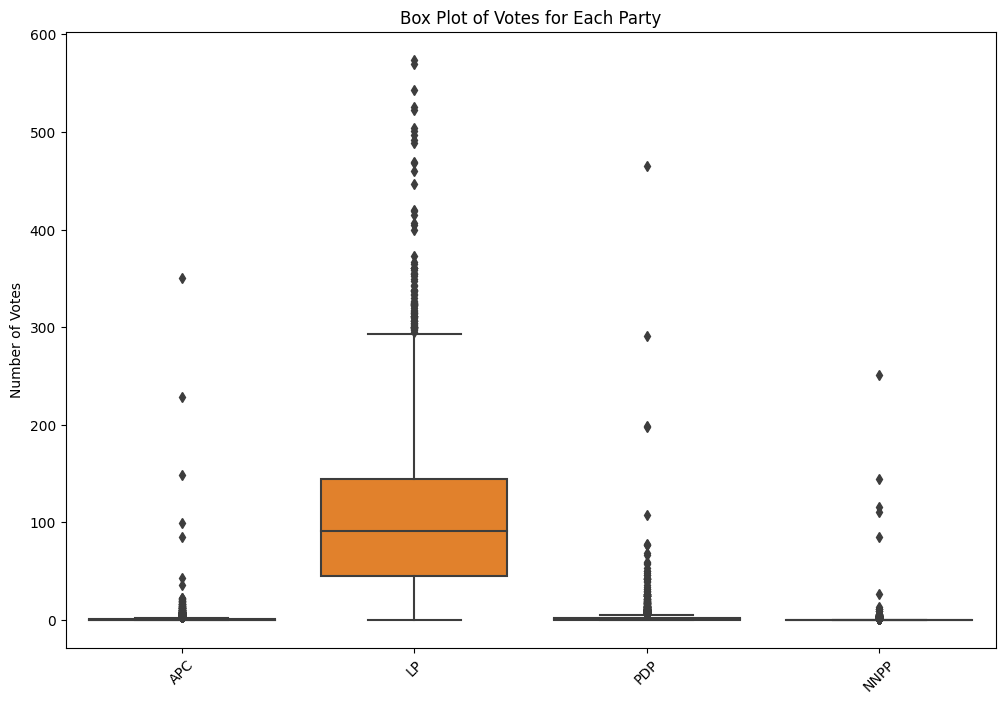

In [18]:
# Create additional visualizations
# Box Plot for Each Voting Column
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[voting_columns])
plt.title('Box Plot of Votes for Each Party')
plt.ylabel('Number of Votes')
plt.xticks(rotation=45)
plt.savefig('Box_Plot_Votes.png')
plt.show()

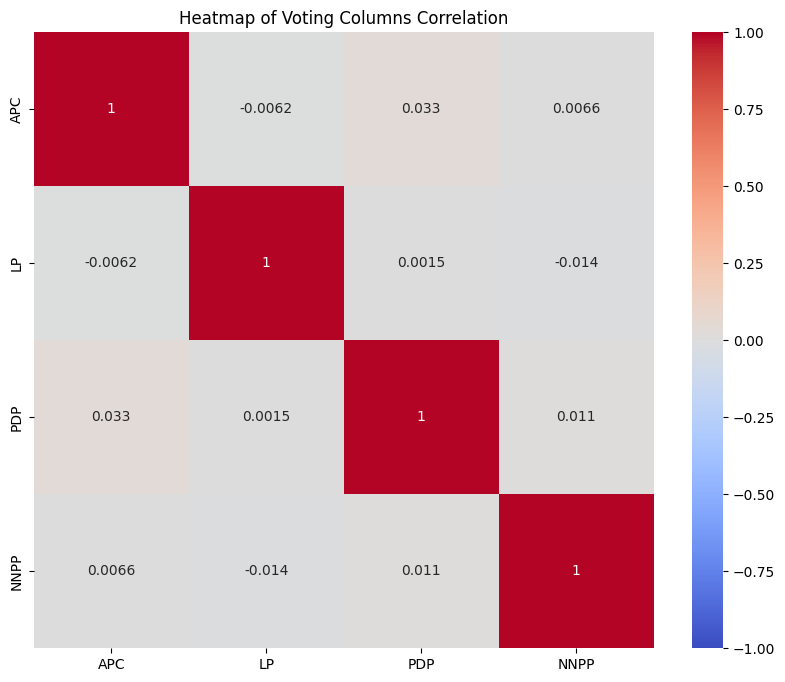

In [19]:
# Heatmap of Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = data[voting_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Voting Columns Correlation')
plt.savefig('Heatmap_Correlation.png')
plt.show()

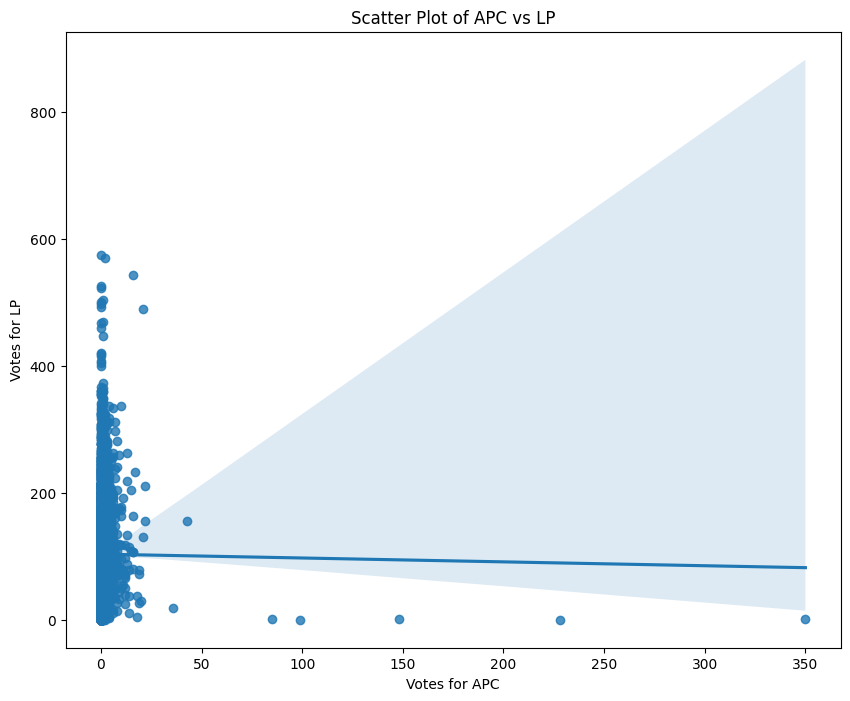

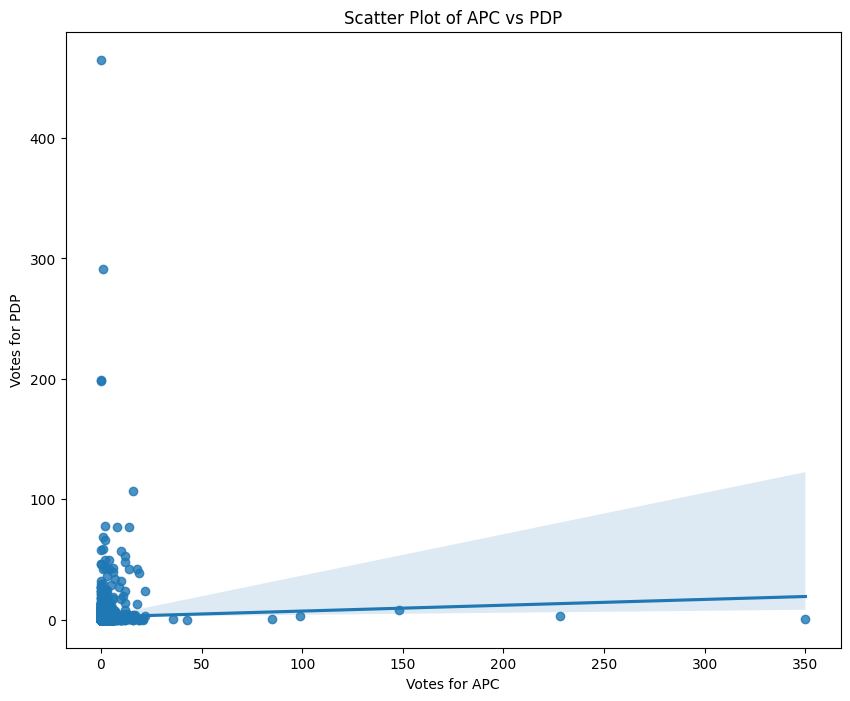

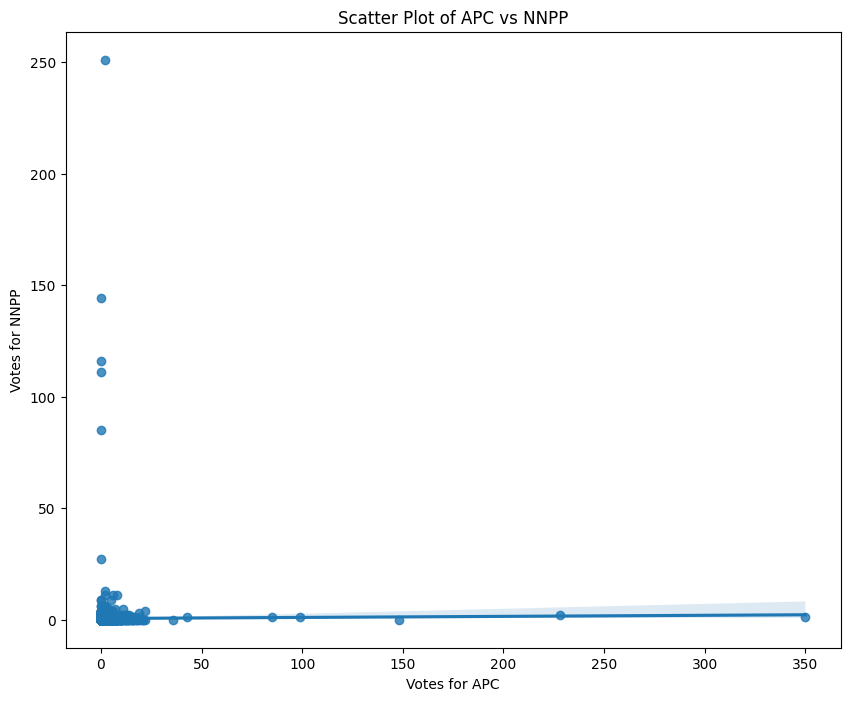

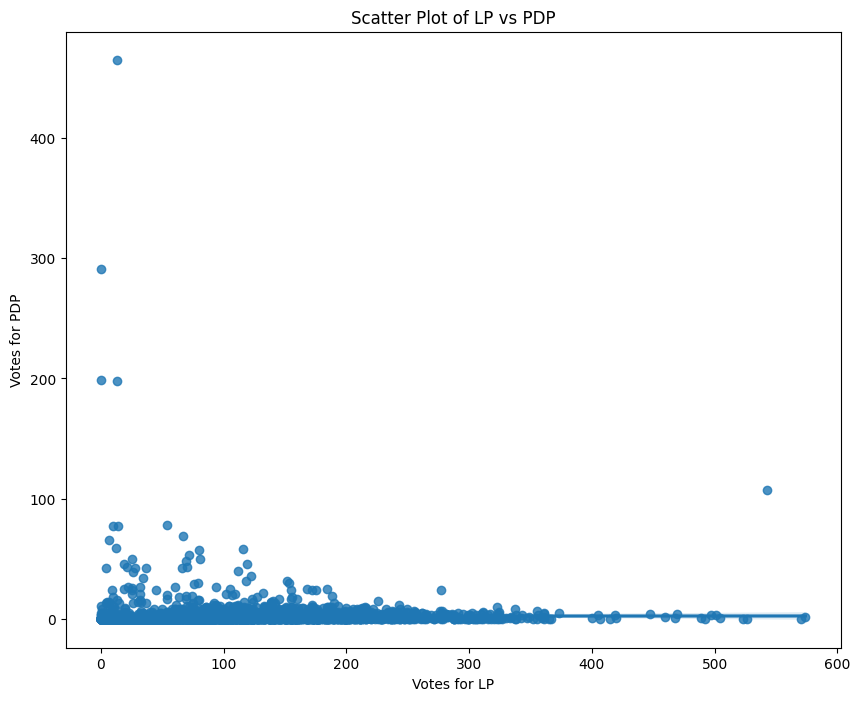

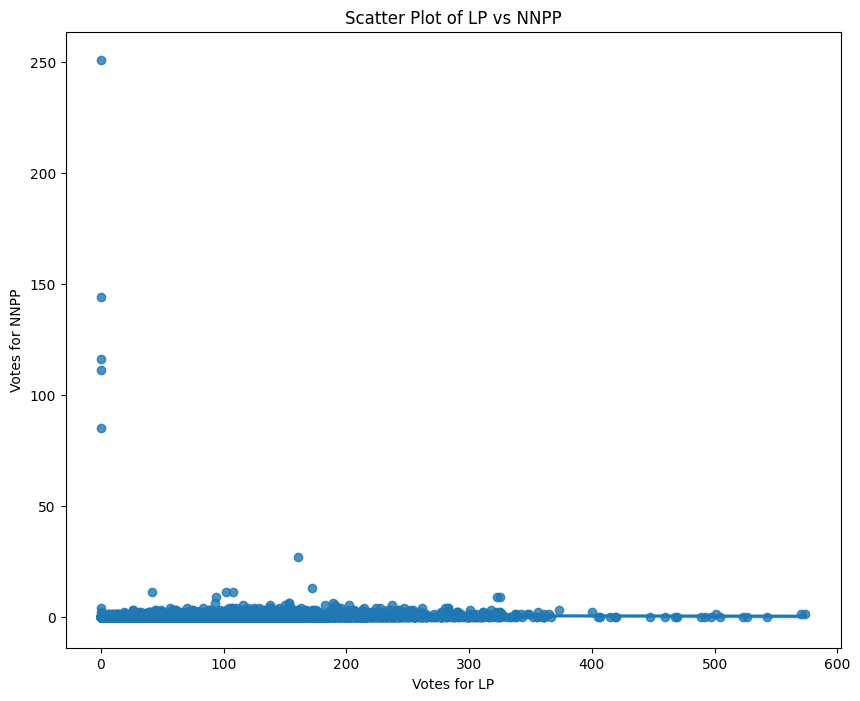

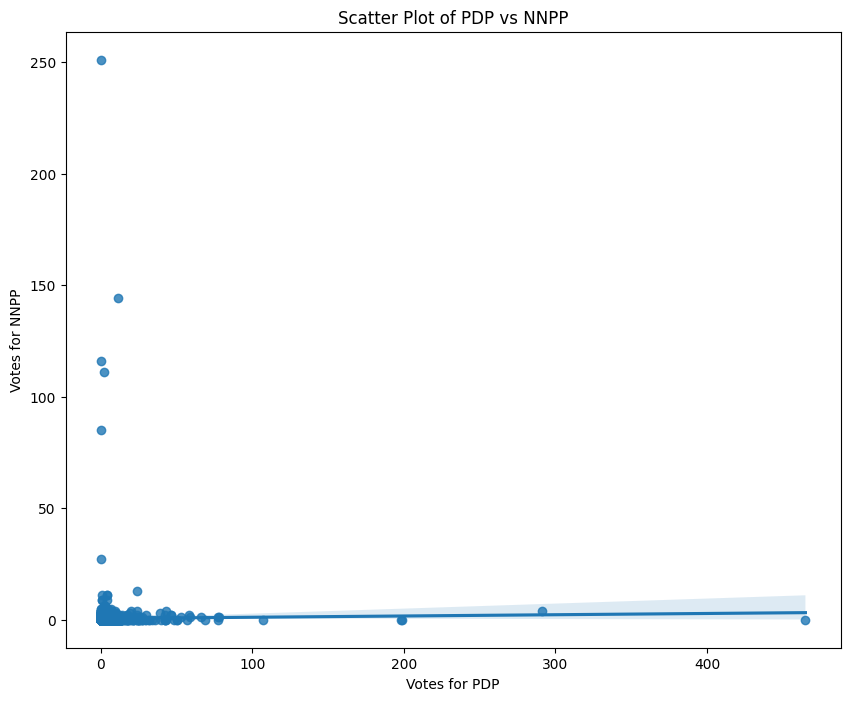

In [20]:
# Scatter Plots with Regression Line
for i in range(len(voting_columns)):
    for j in range(i + 1, len(voting_columns)):
        plt.figure(figsize=(10, 8))
        sns.regplot(x=voting_columns[i], y=voting_columns[j], data=data)
        plt.title(f'Scatter Plot of {voting_columns[i]} vs {voting_columns[j]}')
        plt.xlabel(f'Votes for {voting_columns[i]}')
        plt.ylabel(f'Votes for {voting_columns[j]}')
        plt.savefig(f'Scatter_{voting_columns[i]}_vs_{voting_columns[j]}.png')
        plt.show()